# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
# sns.set_context("talk")
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_test:  (1000, 3, 32, 32)
y_train:  (49000,)
X_train:  (49000, 3, 32, 32)
y_val:  (1000,)
X_val:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})
    
    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    
    assert x.shape == out.shape
    assert x.shape == out_test.shape
    

Running tests with p =  0.3
Mean of input:  9.99698688459
Mean of train-time output:  10.0011290599
Mean of test-time output:  9.99698688459
Fraction of train-time output set to zero:  0.69972
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.99698688459
Mean of train-time output:  9.98283719738
Mean of test-time output:  9.99698688459
Fraction of train-time output set to zero:  0.401044
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.99698688459
Mean of train-time output:  9.99569241061
Mean of test-time output:  9.99698688459
Fraction of train-time output set to zero:  0.250176
Fraction of test-time output set to zero:  0.0


# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

assert dx.shape == dx_num.shape
assert out.shape == x.shape
assert dx.shape == x.shape

dx relative error:  5.44560890598e-11


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in np.linspace(0,0.90,6):
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=125)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print( '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
        assert grad_num.shape == grads[name].shape

Running check with dropout =  0.0
Initial loss:  2.34016739485
('W', 0) relative error: 1.38e-07
('W', 1) relative error: 2.12e-05
('W', 2) relative error: 2.68e-07
('b', 0) relative error: 2.97e-08
('b', 1) relative error: 2.42e-07
('b', 2) relative error: 1.15e-10
Running check with dropout =  0.18
Initial loss:  2.30440602378
('W', 0) relative error: 1.32e-08
('W', 1) relative error: 1.79e-09
('W', 2) relative error: 5.17e-08
('b', 0) relative error: 2.58e-10
('b', 1) relative error: 4.17e-10
('b', 2) relative error: 1.60e-10
Running check with dropout =  0.36
Initial loss:  2.26161469972
('W', 0) relative error: 2.32e-08
('W', 1) relative error: 5.81e-08
('W', 2) relative error: 1.60e-08
('b', 0) relative error: 1.03e-09
('b', 1) relative error: 2.14e-09
('b', 2) relative error: 1.69e-10
Running check with dropout =  0.54
Initial loss:  2.25378421165
('W', 0) relative error: 4.51e-08
('W', 1) relative error: 3.13e-07
('W', 2) relative error: 1.51e-08
('b', 0) relative error: 1.96e-

# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0., 0.20, 0.4, 0.6, 0.8]
weight_scale = 1e-3
for dropout in dropout_choices:
    model = FullyConnectedNet([500], weight_scale=weight_scale, dtype=np.float64, dropout=dropout)
    solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.307184
(Epoch 0 / 25) train acc: 0.102000; val_acc: 0.102000
(Epoch 1 / 25) train acc: 0.144000; val_acc: 0.106000
(Epoch 2 / 25) train acc: 0.264000; val_acc: 0.199000
(Epoch 3 / 25) train acc: 0.342000; val_acc: 0.211000
(Epoch 4 / 25) train acc: 0.408000; val_acc: 0.245000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.219000
(Epoch 6 / 25) train acc: 0.538000; val_acc: 0.242000
(Epoch 7 / 25) train acc: 0.592000; val_acc: 0.266000
(Epoch 8 / 25) train acc: 0.658000; val_acc: 0.247000
(Epoch 9 / 25) train acc: 0.668000; val_acc: 0.244000
(Epoch 10 / 25) train acc: 0.730000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.700000; val_acc: 0.274000
(Epoch 12 / 25) train acc: 0.800000; val_acc: 0.270000
(Epoch 13 / 25) train acc: 0.810000; val_acc: 0.285000
(Epoch 14 / 25) train acc: 0.826000; val_acc: 0.266000
(Epoch 15 / 25) train acc: 0.854000; val_acc: 0.270000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.279000
(Epoch 17 / 25) train acc: 0.882000; val

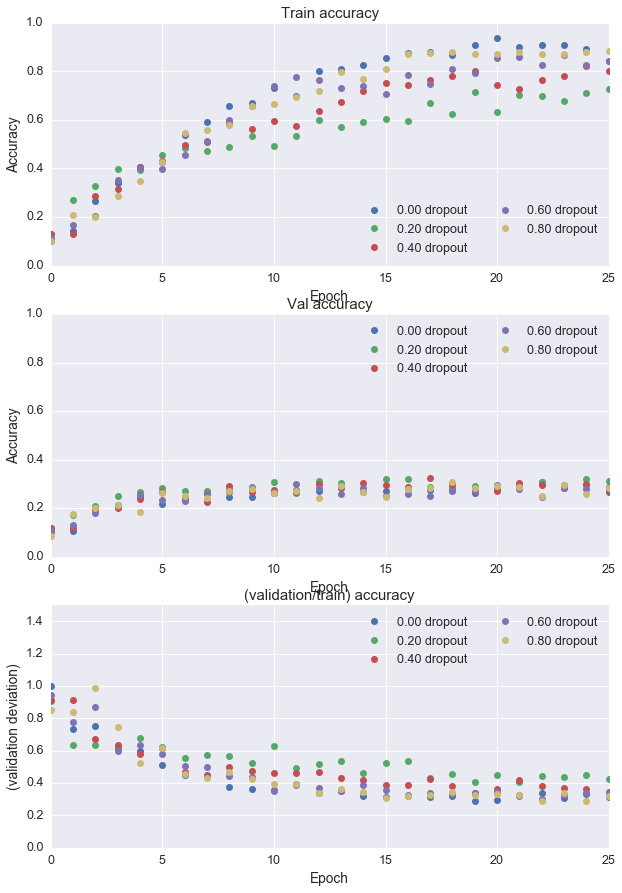

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(4, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axis([0, 25, 0., 1.])
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(4, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axis([0, 25, 0., 1.])
plt.legend(ncol=2, loc='upper right')

plt.subplot(4, 1, 3)
for dropout in dropout_choices:
    plt.plot(np.array(solvers[dropout].val_acc_history)/np.array(solvers[dropout].train_acc_history), 'o', label='%.2f dropout' % dropout)
plt.title('(validation/train) accuracy')
plt.xlabel('Epoch')
plt.ylabel('(validation deviation)')
plt.axis([0, 25, 0., 1.5])
plt.legend(ncol=2, loc='upper right')

plt.gcf().set_size_inches(10, 20)
plt.show()

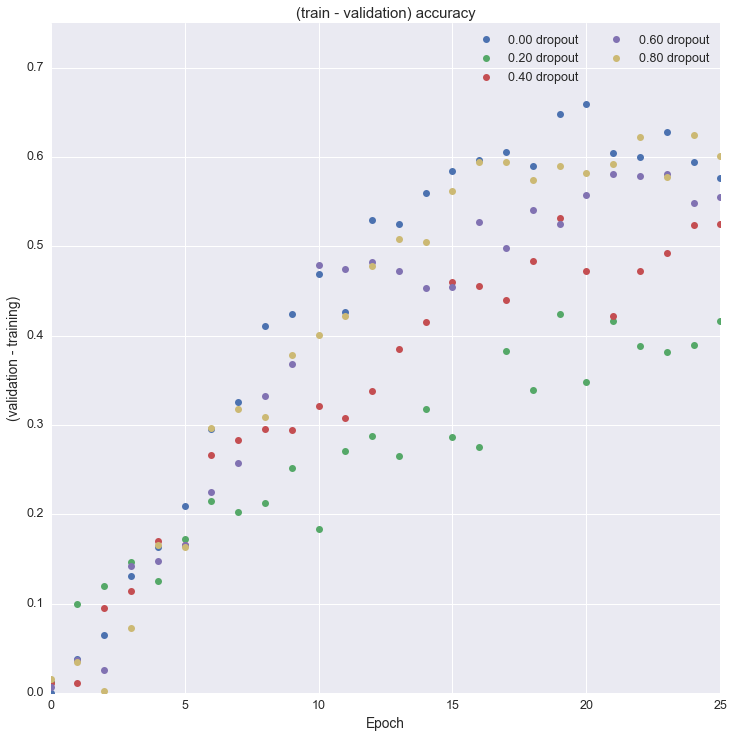

In [9]:
plt.figure(figsize=(12,12))
for dropout in dropout_choices:
    plt.plot(np.array(solvers[dropout].train_acc_history) - np.array(solvers[dropout].val_acc_history), 'o', label='%.2f dropout' % dropout)
plt.title('(train - validation) accuracy')
plt.xlabel('Epoch')
plt.ylabel('(validation - training)')
plt.axis([0, 25, 0, 0.75])
plt.legend(ncol=2, loc='upper right')

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer
Drop out is expected to help improve network 'bias' regularization. A measure for this is the difference between the training accuracy and test/validation accuracy or $$ z= t_{acc} - v_{acc} $$

(1) Assumption that test/validation accuracy is a good measure of the actually neural networks classification accuracy on unseen data.

This ratio is can be viewed as an estimated of how much the overfitting is occuring in the neural network (i.e. if the network is just learning how to just store the training examples, rather than learning how to classify a 'new' unseen example). Naively this is implemented in python as:

```python
def function(validation_acc, training_acc):
    return (training_acc - validation_acc)
```

The above plot shows that for the majority of epochs during training, the network with no dropout has higher intrinsic bias (or overfitting) when compared to any of the networks with some level of bias.